In [2]:
import timm
from PIL import Image
import numpy as np
import cv2
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = timm.create_model("vit_base_patch32_224", num_classes=116)

In [4]:
trained_model = torch.load("../models/vit_base_patch32_224.pt", map_location=torch.device("cpu"))

In [5]:
model.load_state_dict(trained_model["model_state_dict"])

<All keys matched successfully>

In [6]:
with open("../labels.txt") as f:
    prod = []
    for line in f.readlines():
        prod.append(line)

In [7]:
def get_ratio(image):
    h, w, _ = image.shape
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

    pixels = cv2.countNonZero(thresh)
    ratio = (pixels/(h * w)) * 100
    return ratio

In [8]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [9]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

100%|██████████| 1799/1799 [00:37<00:00, 48.26it/s]


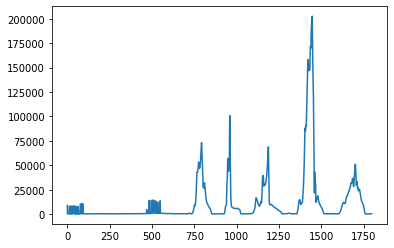

100%|██████████| 1499/1499 [00:36<00:00, 41.49it/s]


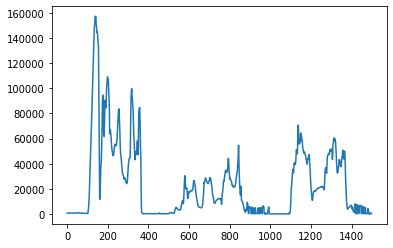

100%|██████████| 3642/3642 [01:20<00:00, 45.05it/s]


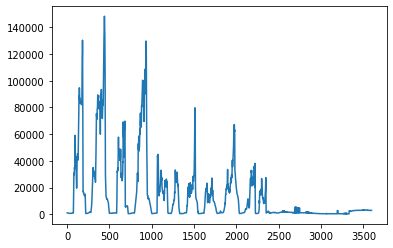

100%|██████████| 2123/2123 [00:51<00:00, 41.10it/s]


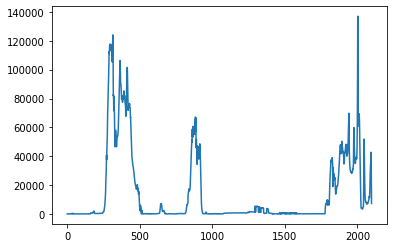

100%|██████████| 1547/1547 [00:42<00:00, 36.24it/s]


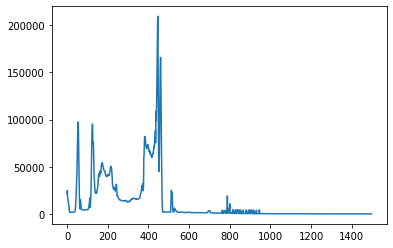

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt 

video_location = "../test-videos/"
videos = ["testA_1.mp4","testA_2.mp4","testA_3.mp4","testA_4.mp4","testA_5.mp4",]
images_list = []
ratios_list = []
colors_list = []
metrics_list = []

for video in videos:
  vidcap = cv2.VideoCapture(video_location+video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[256:896, 512:1400]
      image = automatic_brightness_and_contrast(image)
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []
  colors = []
  metrics = []
  for img in resized_image:
    ratio = get_ratio(img)
    color = image_colorfulness(img)
    metric = color*color*ratio
    # colors.append(color)
    # ratios.append(ratio)
    metrics.append(metric)
  
  images_list.append(resized_image)
  # ratios_list.append(ratios)
  # colors_list.append(colors)
  metrics_list.append(metrics)
  # print(video)
  plt.plot(metrics)
  # plt.plot(ratios)
  # plt.plot(colors)
  plt.show()

In [11]:
import scipy.fftpack as fftpack

def get_sharpness(image):
    im = Image.fromarray(image).convert('L') # to grayscale
    array = np.asarray(im, dtype=np.int32)

    gy, gx = np.gradient(array)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

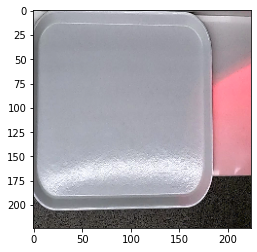

Color 30.468767520042356
Sharp 7.502173687018466
Metric 118.05157713301924


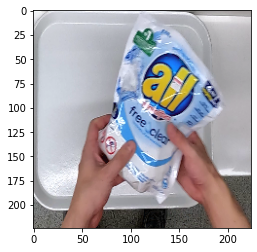

Color 28.001079702596115
Sharp 4.894696186891854
Metric 240.5144535189779


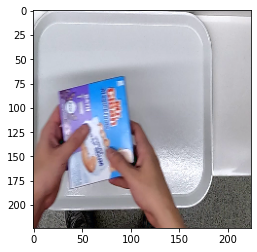

Color 17.943809922527127
Sharp 6.134794232569211
Metric 214.54023103987964


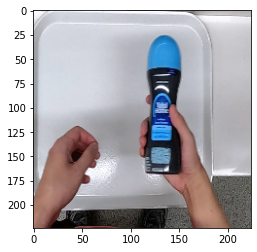

Color 25.58587880201714
Sharp 6.522725759599662
Metric 200.7426384876158


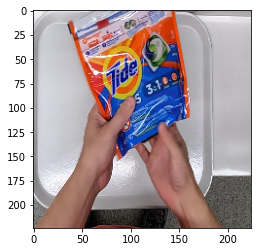

Color 61.599970247427834
Sharp 8.08490419779532
Metric 401.5351879464278


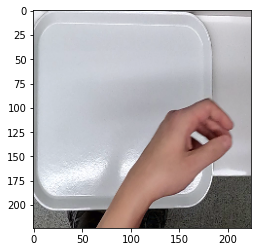

Color 5.901252652913055
Sharp 5.221369177459082
Metric 115.68039096226838


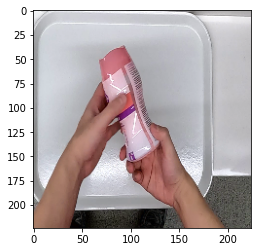

Color 28.534907126734225
Sharp 4.669500728417985
Metric 178.34461598532093


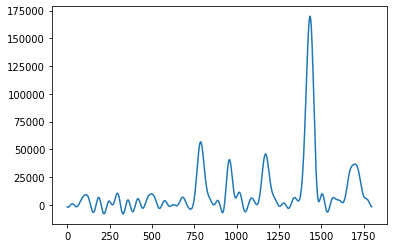

NEXT


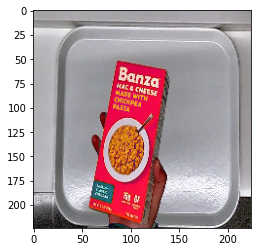

Color 27.212304946741433
Sharp 9.457068633209879
Metric 395.87976129927455


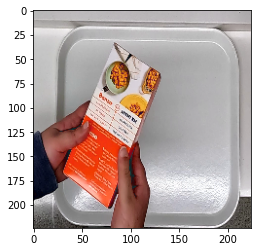

Color 56.14891086644392
Sharp 7.820548274240019
Metric 300.7602028597883


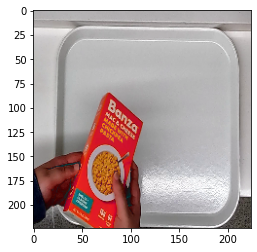

Color 48.10207323231338
Sharp 8.877877200195162
Metric 283.12513640137405


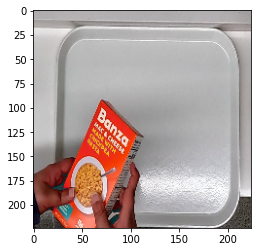

Color 53.64068579434617
Sharp 9.011248043920457
Metric 263.0808026863536


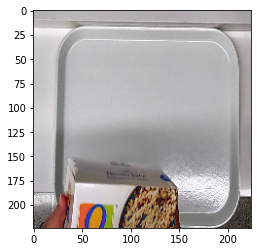

Color 30.839983978229505
Sharp 10.928532220483989
Metric 148.73825027486834


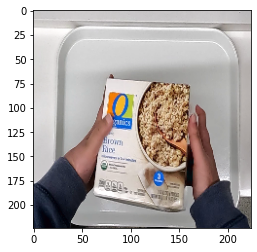

Color 18.06112618174253
Sharp 7.95346191985315
Metric 159.2558189196172


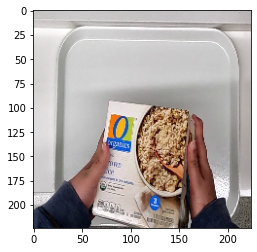

Color 26.220532624815338
Sharp 8.613431396867284
Metric 168.57241197573907


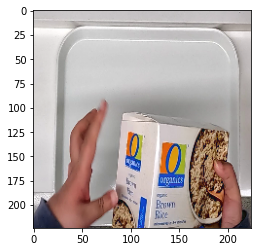

Color 31.692994976560385
Sharp 8.613806135033927
Metric 209.4799458999792


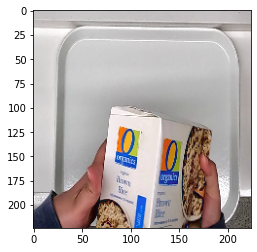

Color 15.496874292327977
Sharp 5.350463694381713
Metric 175.40783421132852


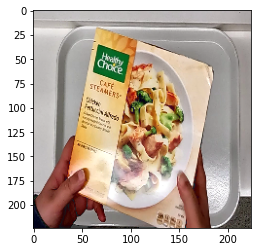

Color 39.51528694052081
Sharp 11.034416771319538
Metric 252.9251821033048


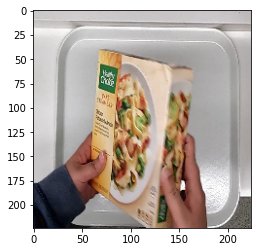

Color 37.05904481987542
Sharp 10.536095521707681
Metric 187.38093387157494


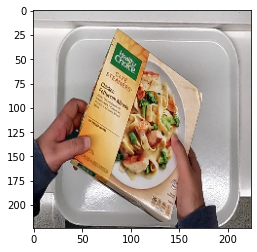

Color 39.00897056807395
Sharp 9.659664580226806
Metric 226.6643656540658


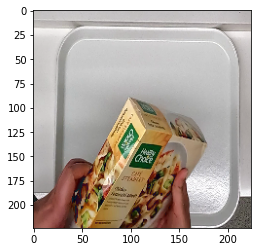

Color 12.051405859133482
Sharp 5.00851287593874
Metric 200.21769504635887


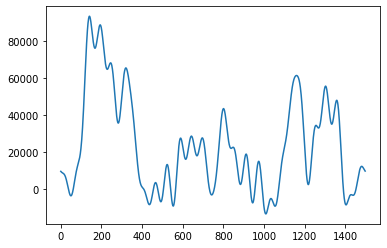

NEXT


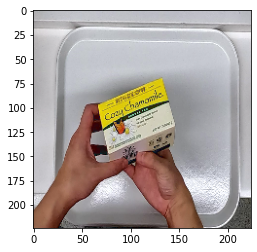

Color 52.21646141354712
Sharp 8.598984892928542
Metric 254.7448218400728


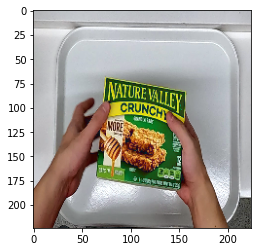

Color 47.442048744592434
Sharp 8.568867974733099
Metric 287.94212701992234


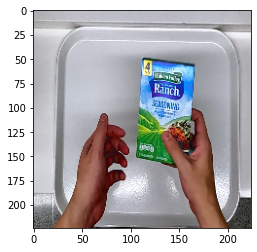

Color 43.961318692681814
Sharp 10.625616120198377
Metric 245.50819213540586


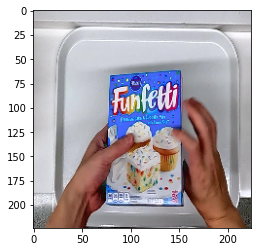

Color 44.54294565754538
Sharp 9.240348986780434
Metric 306.3346390165136


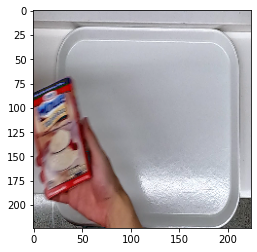

Color 29.52335247822262
Sharp 8.093781384090391
Metric 159.43657062708283


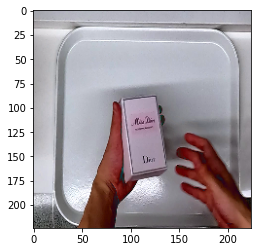

Color 31.45574735664613
Sharp 8.20132082203325
Metric 181.47225057663417


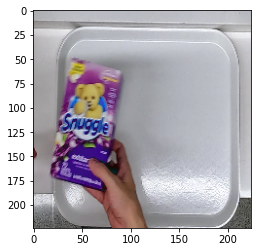

Color 30.487031612860825
Sharp 8.534147911893
Metric 150.54028900314825


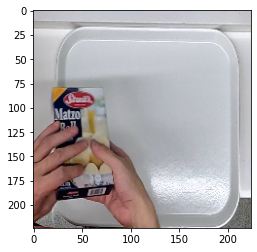

Color 24.37281624313396
Sharp 7.092890191428939
Metric 117.4171949246067


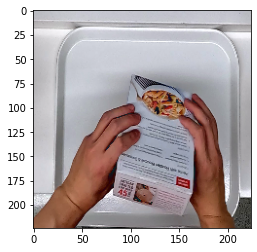

Color 40.592651488689796
Sharp 8.54390664249595
Metric 211.23925333217872


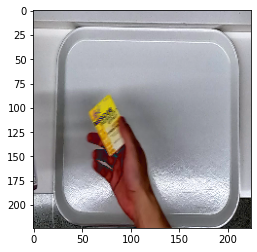

Color 35.22227845088317
Sharp 7.448165833460946
Metric 180.41032855417373


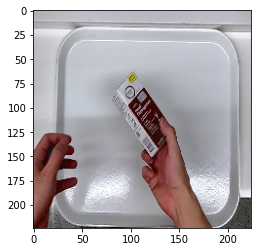

Color 12.003457326191327
Sharp 6.700948548472737
Metric 112.77058576398646


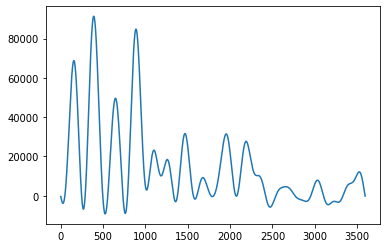

NEXT


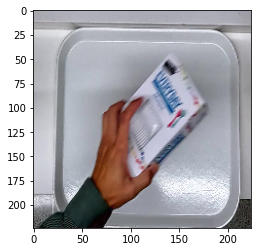

Color 2.880845375601771
Sharp 4.734173815732089
Metric 113.45808952873533


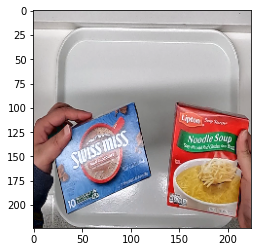

Color 48.12068866589505
Sharp 10.472646798225858
Metric 337.42753965582943


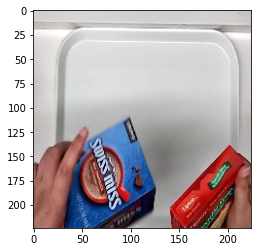

Color 54.4935428569042
Sharp 8.180792667768149
Metric 318.736338911772


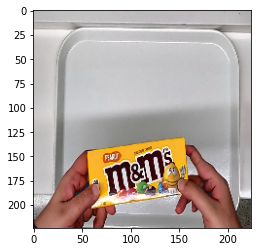

Color 43.15351365142689
Sharp 7.74755288388003
Metric 254.11330958586169


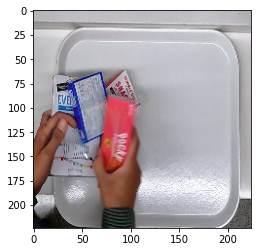

Color 32.64210731046788
Sharp 10.31574975160505
Metric 192.61399418251685


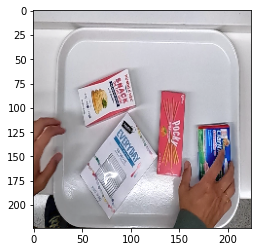

Color 38.18359376557096
Sharp 10.88344967837441
Metric 210.2404485773554


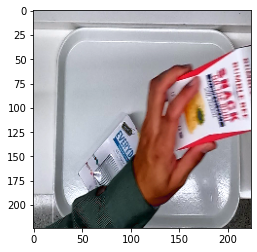

Color 37.780155304078605
Sharp 8.529821491563808
Metric 255.6233722260319


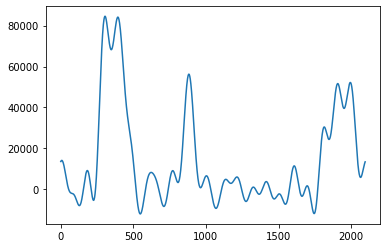

NEXT


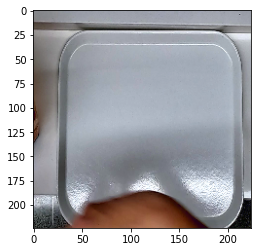

Color 9.312497641322773
Sharp 6.665375070919814
Metric 116.21535495615103


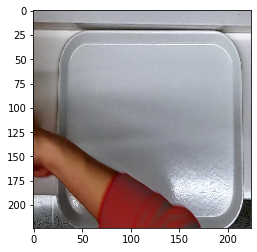

Color 27.795984849777646
Sharp 7.69509666886718
Metric 236.3078275139396


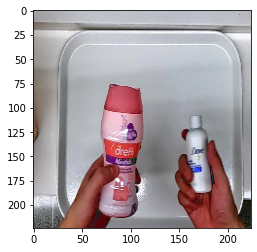

Color 36.84432459648635
Sharp 9.75273428152563
Metric 232.83637367139403


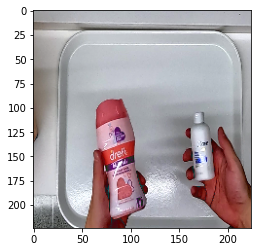

Color 30.58945430015786
Sharp 8.404692574679277
Metric 205.00755194676972


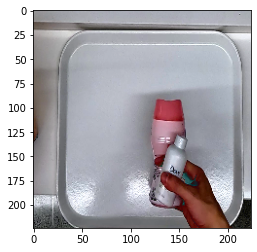

Color 23.00945054917179
Sharp 8.149487965390426
Metric 125.69381726405187


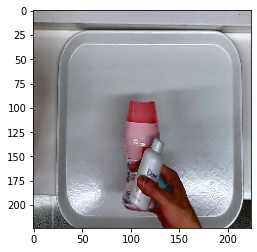

Color 23.706016932543594
Sharp 8.530002074966788
Metric 128.75719011674187


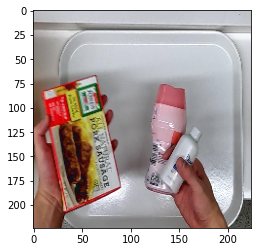

Color 42.83380928756814
Sharp 11.50810471599499
Metric 286.46645749867025


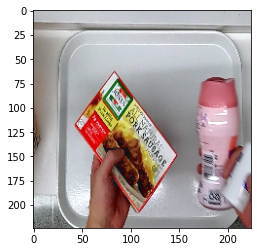

Color 21.54043179123177
Sharp 7.29769887739966
Metric 285.84175687929945


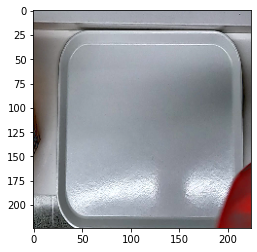

Color 9.253982572196337
Sharp 6.684650593060323
Metric 122.48997858087046


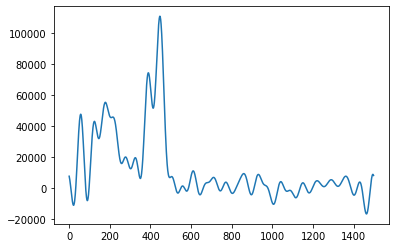

NEXT


In [18]:
from scipy.signal import find_peaks
import math
images_with_object = []

count = 1
for images, colors in zip(images_list, metrics_list):
    frames_with_object = []
    rolling_colors = smooth_data_fft(colors, 20)
    maximas = find_peaks(rolling_colors)
    for maxima in maximas[0]:
        candidate_frame = maxima
        max_sharpness = -1
        max_metric = -1
        for i in range(-21,22,7):
            current_frame = maxima+i
            if(current_frame>=len(images)):
                continue
            sharpness = get_sharpness(images[current_frame])
            colorfulness = image_colorfulness(images[current_frame])
            ratio = get_ratio(images[current_frame])
            metric = colorfulness*colorfulness * ratio
            metric = math.sqrt(metric)
            if(sharpness>max_sharpness and metric>max_metric):
                max_sharpness = sharpness
                max_metric = metric
                candidate_frame = current_frame
        if(max_metric>110):
            frames_with_object.append((images[candidate_frame],candidate_frame))
            count+=1
            plt.imshow(images[candidate_frame][:,:,[2,1,0]])
            plt.show()

            print(f"Color {colorfulness}")
            print(f"Sharp {sharpness}")
            print(f"Metric {max_metric}")

    plt.plot(rolling_colors)
    plt.show()
    print("NEXT")
    images_with_object.append(frames_with_object)

In [19]:
model_path = '../models/unet_aicityt4.pth'

import torchvision

###### UNet model
#########################################################################################
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
        # NOTE: 
        # nn.Conv2d(64, 1, kernel_size=1, padding=0) is mathematically same as 
        # nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)
        return outputs
######################################################################################### 

# Define model
segmentation_model = build_unet()
checkpoint = torch.load(model_path, map_location="cpu")
segmentation_model.load_state_dict(checkpoint)
# Send to GPU
segmentation_model = segmentation_model.to(DEVICE)
segmentation_model.eval()

def visualize(idx, **images):
    """Plot images in one row.""" 
    n = len(images)
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).lower(), fontsize=20)
        plt.imshow(image, cmap='gray')
        plt.axis("off")
        plt.show()

        #plt.tight_layout()
    #plt.savefig("../outputs/vis/compare-segs/{}.png".format(idx), facecolor="white", bbox_inches = 'tight')


In [20]:
#To use this block, run `pip install pytorch-lightning`
#Reference: https://github.com/guglielmocamporese/hands-segmentation-pytorch

# Imports
import torch
import torch.hub

# Create the model
hand_seg_model = torch.hub.load(
    repo_or_dir='guglielmocamporese/hands-segmentation-pytorch', 
    model='hand_segmentor', 
    pretrained=True
)
hand_seg_model.eval()

Using cache found in /home/istiak_admin/.cache/torch/hub/guglielmocamporese_hands-segmentation-pytorch_master
Downloading...
From: https://drive.google.com/uc?id=1w7dztGAsPHD_fl_Kv_a8qHL4eW92rlQg
To: /home/istiak_admin/Codes/classification-pipeline-2/notebooks/checkpoint/checkpoint.ckpt
100%|██████████| 476M/476M [00:45<00:00, 10.4MB/s] 


HandSegModel(
  (deeplab): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [21]:
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters.rank import entropy
from skimage.morphology import disk

transforms_image = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.CenterCrop((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


def crop_with_hand_seg(img):
    """
    Crops product image using product and hand segmentation.
    """
        
    image_b = torch.unsqueeze(img, 0)
    image = (image_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    pred = hand_seg_model(image_b).argmax(1).detach().cpu().numpy().squeeze()
    # invert mask, use plt.imshow(hand_pred) for vis
    hand_pred = np.logical_not(pred).astype(int) 
    
    # Stack preds for getting ROI
    hand_pred3d = np.stack((hand_pred, hand_pred, hand_pred), axis=-1)
    # Get rid off hands
    image_no_hands = np.array(image) * hand_pred3d # use plt.imshow(image_no_hands) for vis
    
    # Convert new image to tensor
    image_no_hands = Image.fromarray(np.uint8(image_no_hands)).convert('RGB')
    image_tensor = transforms_image(image_no_hands)

    image_tensor_b = torch.unsqueeze(image_tensor, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    
    # Image ROI
    image_roi = image_no_hands * mask
    
    data = {"roi": image_roi,
            "mask": pred,
            "image": image
           }
    
    return data

def crop_without_hand_seg(img):
    """
    Crops product image using product segmentation.
    """
    image_tensor_b = torch.unsqueeze(img, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    
    # Image ROI
    image = (image_tensor_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    image_roi = image * mask
    
    data = {"roi": image_roi,
            "mask": pred,
            "image": image
           }
    
    return data


def entropy_based_seg(img):
    image_gray = rgb2gray(img)
    image_gray = img_as_ubyte(image_gray)
    entropy_image = entropy(image_gray, disk(8)) # 6 default
    scaled_entropy = entropy_image / entropy_image.max()
    threshold = scaled_entropy > 0.8 # 0.8 default
    image_seg = np.dstack([img[:,:,0]*threshold,
                            img[:,:,1]*threshold,
                            img[:,:,2]*threshold])
    return image_seg


def crop_with_hand_entropy_seg(img):
    """
    Crops product image using product, hand and entropy based segmentation.
    
    Reference: https://towardsdatascience.com/image-processing-with-python-working-with-entropy-b05e9c84fc36
    """
        
    image_b = torch.unsqueeze(img, 0)
    image = (image_b[0].permute(1,2,0).detach().cpu().numpy()+1)/2
    image = (image*255).astype(np.uint8)
    
    # Hand segmentation
    pred = hand_seg_model(image_b).argmax(1).detach().cpu().numpy().squeeze()
    # invert mask, use plt.imshow(hand_pred) for vis
    hand_pred = np.logical_not(pred).astype(int) 
    
    # Stack preds for getting ROI
    hand_pred3d = np.stack((hand_pred, hand_pred, hand_pred), axis=-1)
    # Get rid off hands
    image_no_hands = np.array(image) * hand_pred3d # use plt.imshow(image_no_hands) for vis
    
    # Convert new image to tensor
    image_no_hands = Image.fromarray(np.uint8(image_no_hands)).convert('RGB')
    image_tensor = transforms_image(image_no_hands)

    image_tensor_b = torch.unsqueeze(image_tensor, 0).to(DEVICE)
    output = torch.sigmoid(segmentation_model(image_tensor_b.float()))
    pred = output.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    
    # Stack preds for getting ROI
    mask = np.stack((pred, pred, pred), axis=-1)
    
    # Image ROI
    image_roi = image_no_hands * mask
    
    # Entropy based segmentation
    image_roi = entropy_based_seg(image_roi)
    
    data = {"roi": image_roi,
            "mask": pred,
            "image": image
           }
    
    return data


In [22]:
def get_blobs(image):
    img = np.array(image)

    # Convert you image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5,5), np.uint8)
    gray = cv2.erode(gray, kernel) 
    # Threshold the image to extract only objects that are not black
    # You need to use a one channel image, that's why the slice to get the first layer
    tv, thresh = cv2.threshold(gray[:,:,0], 1, 255, cv2.THRESH_BINARY)

    # Get the contours from your thresholded image
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    # Create a copy of the original image to display the output rectangles
    output = img.copy()
    contours_areas = []
    # Loop through your contours calculating the bounding rectangles and plotting them
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        contours_areas.append( cv2.contourArea(c))

    rms = np.sqrt(np.mean(np.array(contours_areas)**2))

    bounding_boxes = []

    for c,area in zip(contours, contours_areas):
        if(area<rms):
            continue
        x, y, w, h = cv2.boundingRect(c)
        bounding_boxes.append((x,y,w,h))
        cv2.rectangle(output, (x,y), (x+w, y+h), (0, 0, 255), 2)

    
    # Display the output image

    # c = max(contours, key=cv2.contourArea)
    # x,y,w,h = cv2.boundingRect(c)
    plt.imshow(output)
    plt.show()
    return bounding_boxes

In [23]:

transforms_image = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.CenterCrop((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



def preprocess_image_classification(frame):
   img = Image.fromarray(frame).convert('RGB')

   mean = [0.4124, 0.3856, 0.3493] 
   std = [0.2798, 0.2703, 0.2726]
   test_transforms = timm.data.create_transform(
      input_size=224, mean=mean, std=std
   )
   img_normalized = test_transforms(img).float()
   return img_normalized

def infer_frame(frame, model):
   indices = []
   img = Image.fromarray(frame).convert('RGB')
   img = transforms_image(img)
   segmented_image = crop_with_hand_entropy_seg(img)["roi"]
   bounding_boxes = get_blobs(segmented_image)
   for (x,y,w,h) in bounding_boxes:
      image_roi = frame[y:y+h, x:x+w]
      img = image_roi
      # img = Image.fromarray(image_roi).convert('RGB')
      # img = transforms_image(img)
      # img = crop_with_hand_entropy_seg(img)["roi"]
      color = image_colorfulness(img)
      ratio = get_ratio(img)
      metric = math.sqrt(color*color * ratio)
      if(metric>120):
         plt.imshow(image_roi[:,:,[2,1,0]])
         plt.show()
         img_normalized = preprocess_image_classification(frame=image_roi[:,:,[2,1,0]])
         img_normalized = img_normalized.unsqueeze_(0)
         img_normalized = img_normalized.to("cpu")
         with torch.no_grad():
            model.eval()
            output =model(img_normalized)
            index = output.data.cpu().numpy().argmax()
            op_array = output.data.cpu().numpy()
            print(metric)
            print(op_array[0][index])
            print(prod[index])
            indices.append(index+1)
   return indices


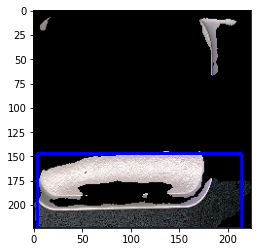

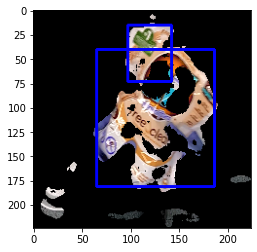

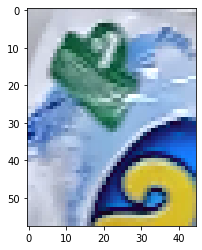

343.26663235632265
7.087309
Brown Rice,18



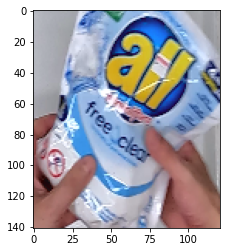

384.4211750788269
12.502985
All Free and Clear Pods,6



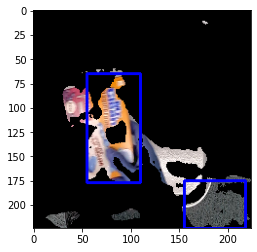

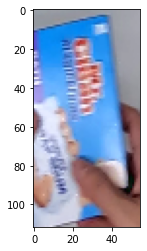

521.1729631728242
7.9616075
Glad Drawstring Trash Bag,50



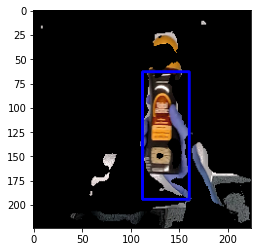

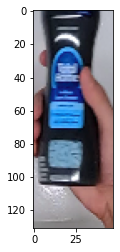

355.97823428827235
7.2138386
Total Home Scent Boos,106



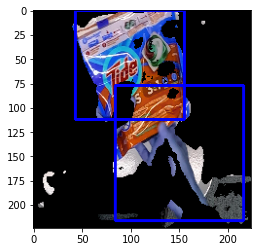

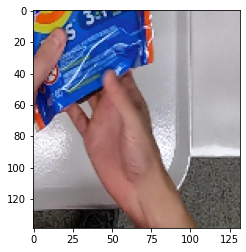

392.9666939498695
6.8922353
Tide Pods,103



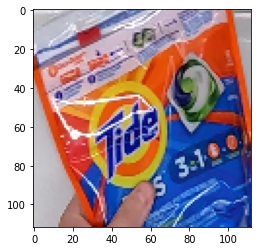

675.9255934027881
12.673351
Tide Pods,103



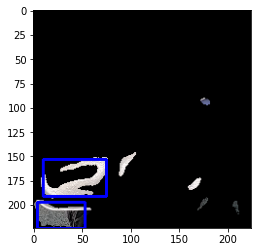

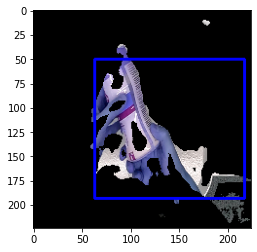

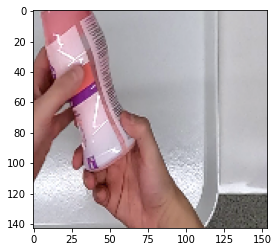

205.93892575859275
7.474649
Unstoppables,109



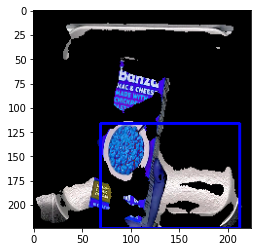

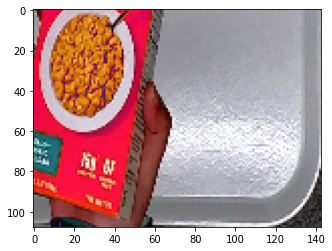

638.9650283097485
7.675414
Banza,9



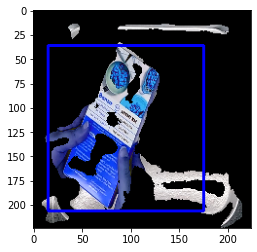

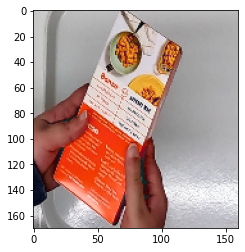

446.21315719584356
11.208118
Banza,9



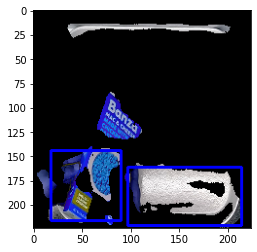

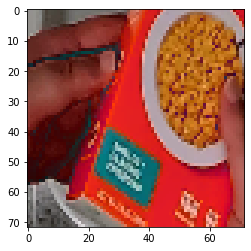

848.9774203123836
8.257849
Banza,9



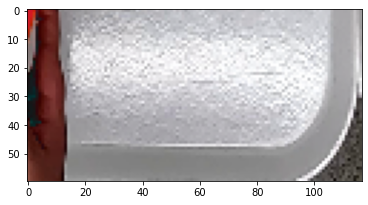

132.30278373628744
10.549228
Miss Dior,71



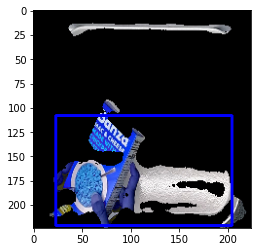

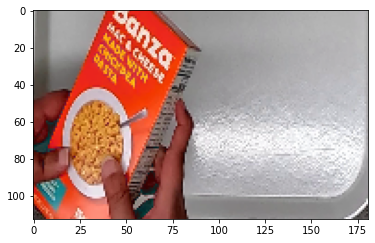

506.9952042083879
11.517509
Banza,9



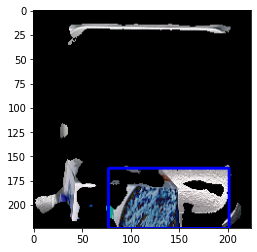

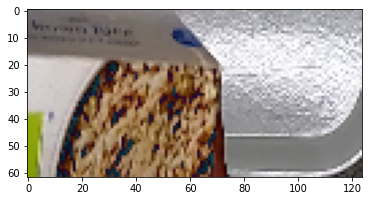

288.9554455726156
7.4318395
Brown Rice,18



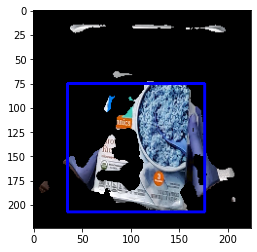

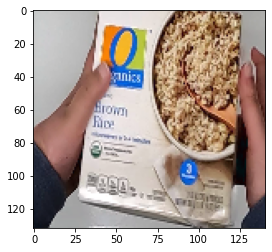

300.1394670335936
13.950964
Brown Rice,18



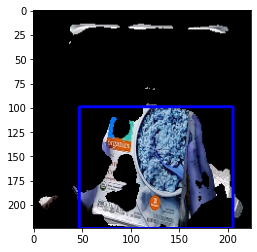

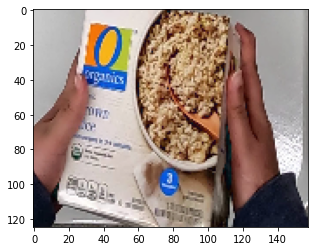

319.85929280961807
13.169155
Brown Rice,18



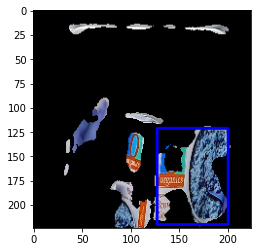

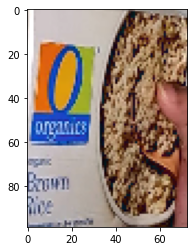

378.9712335928473
14.30571
Brown Rice,18



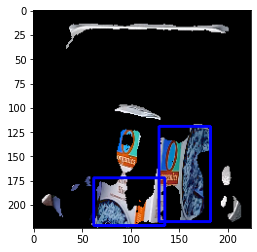

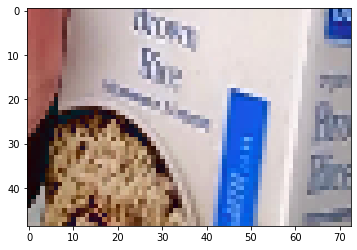

355.53461382302686
8.730971
Brown Rice,18



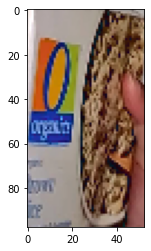

342.56860009781724
12.639946
Brown Rice,18



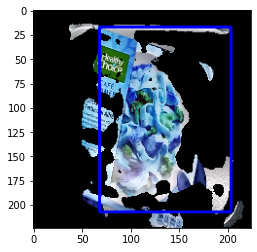

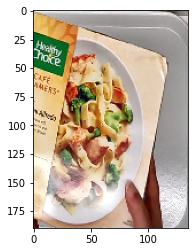

373.03558245487864
9.157176
Healthy Choice Chicken Alfredo,54



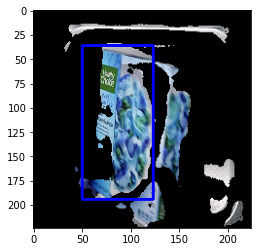

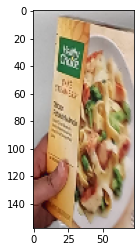

299.12205010068584
11.326556
Healthy Choice Chicken Alfredo,54



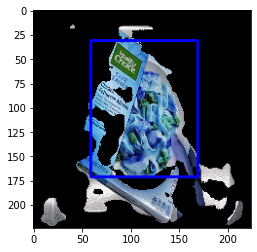

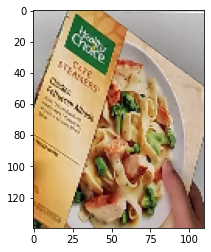

296.92360378244297
10.035857
Healthy Choice Chicken Alfredo,54



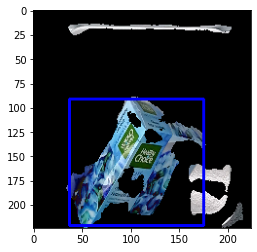

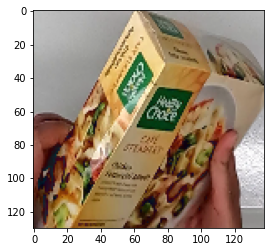

287.3704816965918
14.405402
Healthy Choice Chicken Alfredo,54



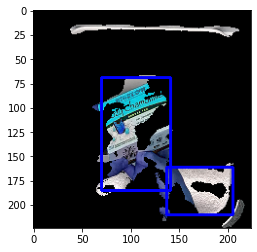

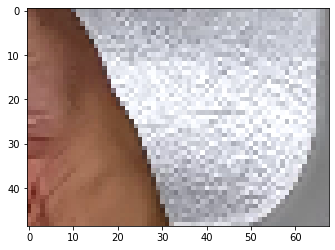

241.88895970048907
5.019971
Wild Strawberry Tea,115



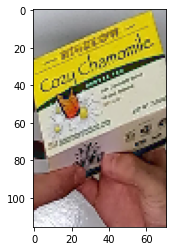

553.5599332622697
10.522348
Chamomile Tea,21



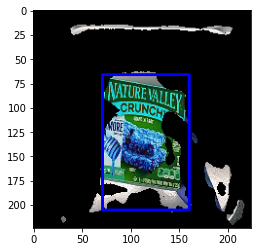

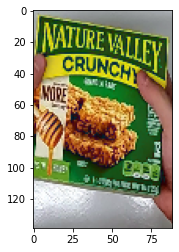

492.7086082759652
10.626333
Nature Valley Granola Bars,80



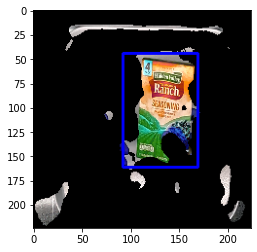

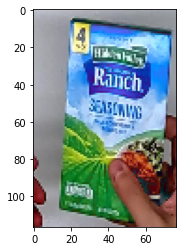

472.95386744781285
15.092014
Ranch Seasoning,91



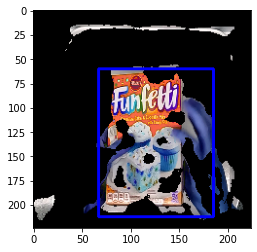

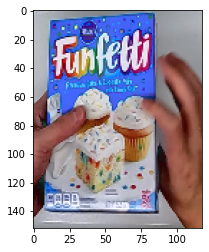

524.2111109779768
12.373385
Funfetti Cake,46



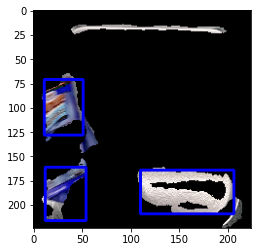

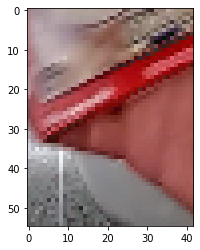

365.41303174695366
5.7568483
Dreft Scent Beads,37



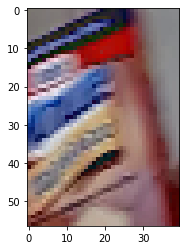

315.3868480399239
8.339156
Minute Tapioca,70



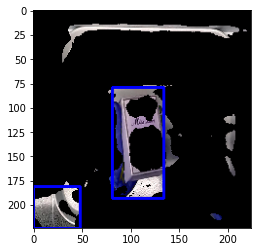

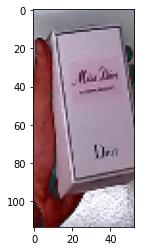

223.28727121549414
6.5370536
Playtex Sport,86



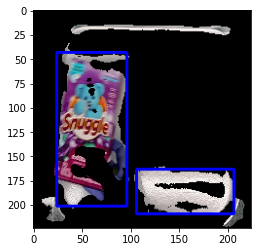

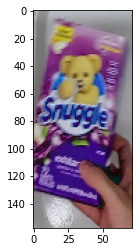

336.77887100766816
12.989678
Snuggle Dryer Sheets,95



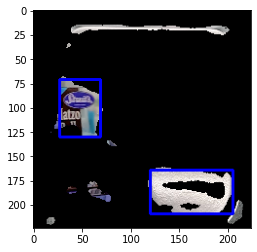

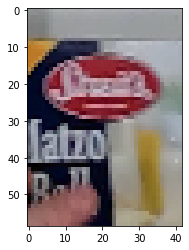

226.6466246015588
12.075012
Matzo Balls,67



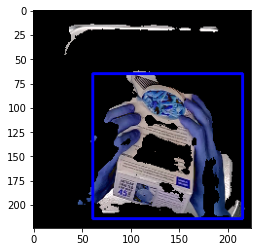

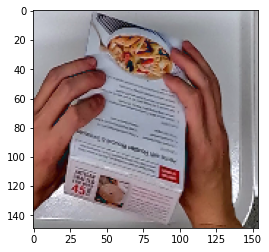

246.34101039821203
7.559834
Gluten Free Pasta,52



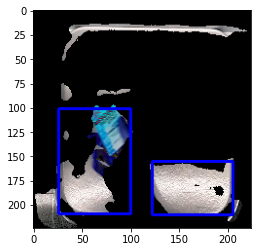

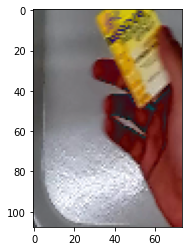

472.5200840316034
5.0021772
McCormick Natures Food Coloring,68



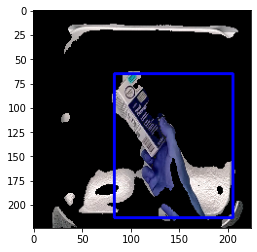

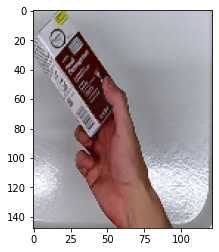

149.73001653258154
5.0287876
McCormick Natures Food Coloring,68



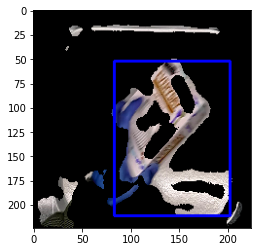

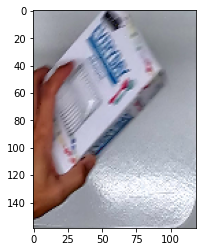

155.2694497461138
9.6669
Heavy Duty Forks,55



KeyboardInterrupt: 

In [24]:

video_id = []
object_id = []
timestamp = []
for idx in range(len(images_with_object)):
    for image,frame in images_with_object[idx]:
        indices = infer_frame(image, model)
        for output in indices:
            video_id.append(idx+1)
            object_id.append(output)
            timestamp.append(int(frame/60))    

In [ ]:
with open('vit_contour_mot_with_seg.txt', 'w') as f:

    prev_vid = -1
    prev_obj = -1
    for vid, obj, tim in zip(video_id, object_id, timestamp):
        if(vid==prev_vid and obj==prev_obj):
            continue
        f.write(f'{vid} {obj} {tim}\n')
        prev_vid = vid
        prev_obj = obj
    f.close()
    

In [ ]:
# count = 0
# for idx in range(len(images_with_object)):
#     for image,frame in images_with_object[idx]:
#         plt.imsave("./test_image/image"+str(count)+".jpg", image[:,:,[2,1,0]])
#         count+=1